# Simulate reservoir routine
***

**Author:** Chus Casado Rodríguez<br>
**Date:** 27-06-2024<br>

**Introduction:**<br>
This code simulates all the reservoirs included both in GloFASv4 and ResOpsUS according to the reservoir routine defined in the configuration file (attribute `simulation>model`).

The inflow time series is taken from GloFASv4 simulations, and the initial storage from the observed records.

>Note. The `Shrestha` reservoir routine requires a time series of water demand as input. Since that time series is not available, the code creates a fake demand by a transformation of the input time series.

**To do:**<br>
* [ ] When using the `Lisflood` model, some parameters could be estimated according to the records:
```Python
# storage limits
Vn_adj = get_normal_value(obs.storage) 
Vn = 1 * Vn_adj
Vtot = reservoirs.loc[grand_id, 'CAP'] * 1e6
Vf = Vtot - .2 * (Vtot - Vn_adj)

# outflow limits
if obs.outflow.isnull().all():
    Qn = reservoirs.loc[grand_id, 'normq_adj']
else:
    Qn = get_normal_value(obs.outflow) 
if obs.inflow.isnull().all():
    Qmin, Qnd = Qmin, Qnd = reservoirs.loc[grand_id, ['minq', 'ndq']]
else:
    Q100 = return_period(obs.inflow, T=100)
    Qnd = .3 * Q100
    Qmin = obs.inflow.groupby(obs.index.year).quantile(.05).mean()
Qmin = np.min([Qmin, Qn])
```

**Ideas:**<br>


In [1]:
import sys
sys.path.append('../../src/')
import os
os.environ['USE_PYGEOS'] = '0'
import numpy as np
import pandas as pd
import geopandas as gpd
from tqdm.auto import tqdm
from pathlib import Path
import yaml

from lisfloodreservoirs.models import get_model
from lisfloodreservoirs.utils.metrics import KGEmod
from lisfloodreservoirs.utils.utils import get_normal_value, return_period

## Configuration

In [2]:
with open('config_mHM_outflow.yml', 'r', encoding='utf8') as ymlfile:
    cfg = yaml.load(ymlfile, Loader=yaml.FullLoader)

### Paths
# PATH_GLOFAS = Path(cfg['paths']['GloFAS'])
PATH_RESOPS = Path(cfg['paths']['ResOpsUS'])
# PATH_GRAND = Path(cfg['paths']['GRanD'])

### Reservoir model
MODEL = cfg['simulation']['model'].lower()
MODEL_CFG = cfg['simulation'].get('config', {})

# default simulation results will be saved in this path
PATH_OUT = Path(f'{MODEL}/default')
PATH_OUT.mkdir(parents=True, exist_ok=True)
print(f'Default simulation results will be saved in {PATH_OUT}')

# calibration
ALGORITHM = cfg['calibration']['algorithm'].lower()
TARGET = cfg['calibration']['target']
MAX_ITER = cfg['calibration'].get('max_iter', 1000)
COMPLEXES = cfg['calibration'].get('COMPLEXES', 4)
TRAIN_SIZE = cfg['calibration'].get('TRAIN_SIZE', 0.7)

# calibration results will be saved in this path
PATH_CALIB = Path('./') / MODEL / 'calibration' / ALGORITHM
if len(TARGET) == 1:
    PATH_CALIB = PATH_CALIB / 'univariate' / TARGET[0]
elif len(TARGET) == 2:
    PATH_CALIB /= 'bivariate'
else:
    print('ERROR. Only univariate or bivariate calibrations are supported')
    sys.exit()
PATH_CALIB.mkdir(parents=True, exist_ok=True)
print(f'Calibration results will be saved in {PATH_CALIB}')

Default simulation results will be saved in mhm\default
Calibration results will be saved in mhm\calibration\sceua\univariate\storage


In [3]:
variables = ['inflow', 'storage', 'outflow']

## Data

### Attributes

In [4]:
# import all tables of attributes
path_attrs = PATH_RESOPS / 'attributes'
try:
    attributes = pd.concat([pd.read_csv(file, index_col='GRAND_ID') for file in path_attrs.glob('*.csv')], axis=1, join='outer')
except Exception as e:
    raise ValueError('ERROR while reading attribute tables: {}'.format(e)) from e
print(f'{attributes.shape[0]} reservoirs in the attribute tables')

# keep only reservoirs with all observed variables
mask = pd.concat([attributes[var.upper()] == 1 for var in variables], axis=1).all(axis=1)
attributes = attributes[mask]
print('{0} reservoirs include observed timeseris for all variables: {1}'.format(attributes.shape[0],
                                                                                *variables))

526 reservoirs in the attribute tables
231 reservoirs include observed timeseris for all variables: inflow


In [5]:
attributes = attributes.loc[[41]]

#### Time series

Time series of reservoirs simulated in GloFAS, as the GloFAS simulated inflow will be used as the forcing of the reservoir module.

In [6]:
path_ts = PATH_RESOPS / 'time_series' / 'csv'
timeseries = {}
for grand_id in tqdm(attributes.index, desc='reading time series'):
    file = path_ts / f'{grand_id}.csv'
    if file.is_file():
        ts = pd.read_csv(file, parse_dates=True, index_col='date')
    else:
        print(f"File {file} doesn't exist")
        continue
    # select columns associated with variables of interest
    select_columns = [col for col in ts.columns if col.split('_')[0] in variables]
    ts = ts[select_columns]
    # if not ts.columns.str.contains('glofas').any():
    #     print(f'{grand_id} does not contain GloFAS simulated time series')
    #     continue
    # invert normalization
    capacity = attributes.loc[grand_id, 'CAP_MCM'] * 1e6
    ts *= capacity
    ts.iloc[:, ts.columns.str.contains('inflow')] /= (24 * 3600)
    ts.iloc[:, ts.columns.str.contains('outflow')] /= (24 * 3600)
    # save time series
    timeseries[grand_id] = ts
    
print(f'{len(timeseries)} reservoirs with timeseries')

reading time series:   0%|          | 0/1 [00:00<?, ?it/s]

1 reservoirs with timeseries


## Reservoir routine
### Simulate all reservoirs

In [7]:
# GloFAS reservoir
for grand_id in tqdm([41], desc='simulating reservoir'): # 146 #302 #273 #236 #227
    
    ts = timeseries[grand_id]
    
    # file where the simulation results will be saved
    file_out = PATH_OUT / f'{grand_id:03}_performance.csv'
    if file_out.is_file():
        print(f'The file {file_out} already exists.')
        continue

simulating reservoir:   0%|          | 0/1 [00:00<?, ?it/s]

The file mhm\default\041_performance.csv already exists.


In [8]:
    ## TIME SERIES
    # observed time series
    obs = ts[ts.columns.intersection(variables)].copy()
    start = np.max([obs[var].first_valid_index() for var in variables])
    end = np.min([obs[var].last_valid_index() for var in variables])
    obs = obs.loc[start:end]
    obs.ffill(axis=1, inplace=True)

In [9]:
    # storage limits (m3)
    Vtot, Vmin = attributes.loc[grand_id, ['CAP_MCM', 'Vmin']]
    Vtot *= 1e6
    Vmin *= Vtot
    # outflow limits (m3/s)
    Qmin = attributes.loc[grand_id, 'Qmin']

In [10]:
    # estimate demand time series
    water_stress = .75
    demand_m = obs.outflow.groupby(obs.index.month).mean() * water_stress
    demand = pd.Series({date: demand_m.loc[date.month] for date in obs.index})

In [11]:
# demand_d = obs.outflow.groupby([obs.index.month, obs.index.day]).mean() * water_stress

In [12]:
foo = obs.outflow.groupby([obs.index.month, obs.index.day]).mean() * water_stress
foo = pd.concat((foo, foo, foo), axis=0)
foo.index = np.arange(1, foo.shape[0] + 1)
foo.head()

1    75.615800
2    86.759125
3    82.136400
4    80.421150
5    85.501875
Name: outflow, dtype: float64

In [13]:
# foo.rolling(7, center=True).mean().plot()
demand_d = foo.rolling(28, center=True).mean()
t = int(demand_d.shape[0] / 3)
demand_d = demand_d.loc[t:2*t]
demand_d.index = np.arange(1, demand_d.shape[0] + 1)

In [14]:
demand = pd.Series({date: demand_d.loc[date.dayofyear] for date in obs.index})

In [15]:
# normal filling
gamma = obs.storage.quantile(.9) / Vtot

In [16]:
obs.inflow.mean() * 365 * 24 * 3600

2882798462.4840865

In [17]:
Vtot

1791900000.0

In [18]:
Vtot / (obs.inflow.mean() * 365 * 24 * 3600)

0.6215835145325882

In [19]:
    # keyword arguments
    reservoir_kwargs = {'Vmin': Vmin,
                        'Vtot': Vtot,
                        'Qmin': Qmin,
                        'avg_inflow': obs.inflow.mean(),
                        'avg_demand': demand.mean(),
                        'gamma': gamma}
    simulation_kwargs = {'demand': demand}

In [20]:
    # # export default parameters
    # with open(PATH_OUT / f'{grand_id:03}_default_parameters.yml', 'w') as file:
    #     yaml.dump(kwargs, file)
    
    # declare the reservoir
    res = get_model(MODEL, **reservoir_kwargs)

    # simulate the reservoir
    sim = res.simulate(inflow=obs.inflow, Vo=obs.storage.iloc[0], **simulation_kwargs)

    # # analyse simulation
    # performance = pd.DataFrame(index=['KGE', 'alpha', 'beta', 'rho'], columns=obs.columns)
    # for var in performance.columns:
    #     try:
    #         performance[var] = KGEmod(obs[var], sim[var])
    #     except:
    #         continue
    # performance.to_csv(file_out, float_format='%.3f')

  0%|          | 0/10956 [00:00<?, ?it/s]

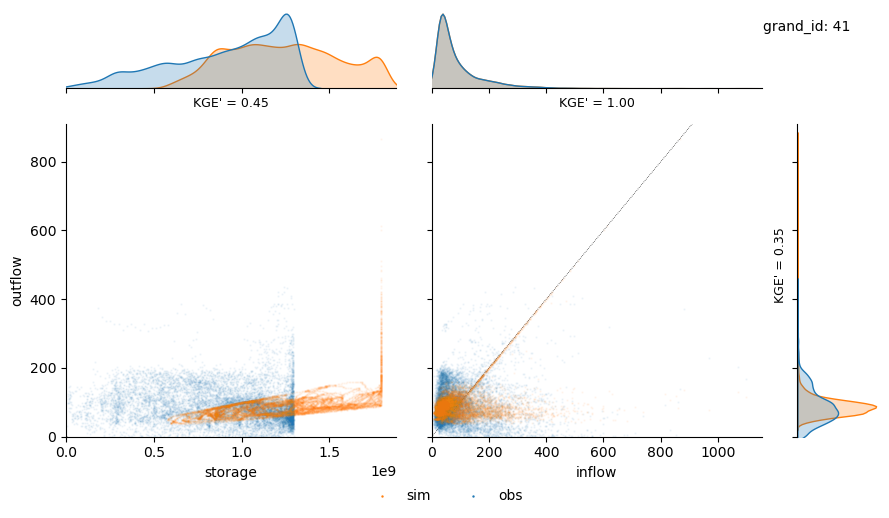

In [21]:
    res.scatter(sim,
                obs,
                norm=False,
                title=f'grand_id: {grand_id}',
                # save=PATH_OUT / f'{grand_id}_scatter_default.jpg',
               )

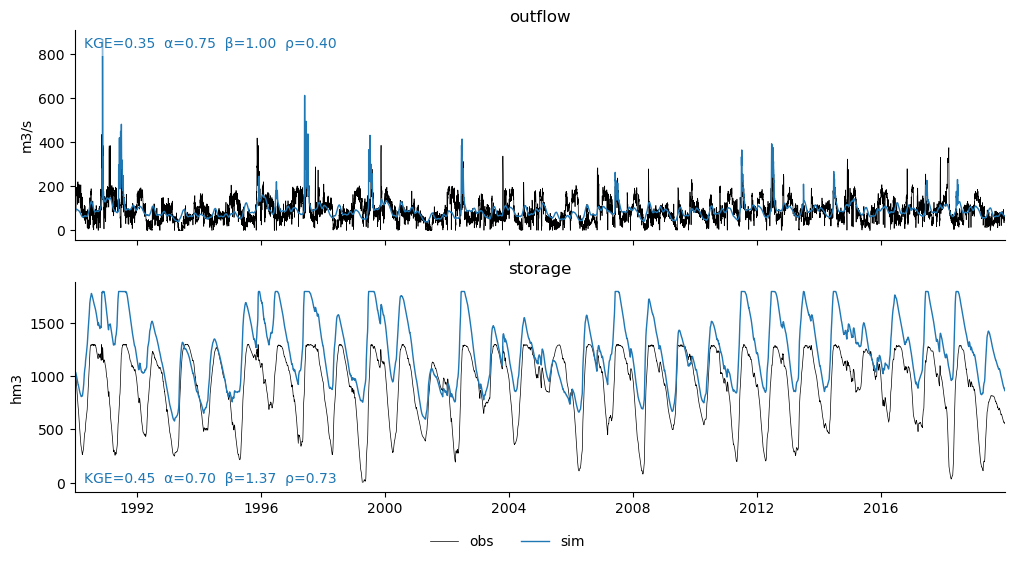

In [22]:
    res.lineplot({#'GloFAS': glofas, 
                  'sim': sim},
                 obs,
                 figsize=(12, 6),
                 # save=PATH_OUT / f'{grand_id}_line_default.jpg',
               )

## Calibration

In [23]:
from lisfloodreservoirs.calibration import get_calibrator, read_results
import spotpy

In [ ]:
dbname = f'{PATH_CALIB}/{grand_id}_samples'

# initialize the calibration setup of the LISFLOOD reservoir routine
setup = get_calibrator(MODEL,
                       inflow=obs.inflow,
                       storage=obs.storage, 
                       outflow=obs.outflow,
                       Vmin=Vmin,
                       Vtot=Vtot,
                       Qmin=Qmin,
                       target=TARGET,
                       obj_func=KGEmod,
                       **{'demand': demand})

# define the sampling method
sceua = spotpy.algorithms.sceua(setup, dbname=dbname, dbformat='csv', save_sim=False)

# start the sampler
sceua.sample(MAX_ITER, ngs=COMPLEXES, kstop=3, pcento=0.01, peps=0.1)

Initializing the  Shuffled Complex Evolution (SCE-UA) algorithm  with  1000  repetitions
The objective function will be minimized
Starting burn-in sampling...


  0%|          | 0/10956 [00:00<?, ?it/s]

Initialize database...
['csv', 'hdf5', 'ram', 'sql', 'custom', 'noData']
* Database file 'mhm\calibration\sceua\univariate\storage/41_samples.csv' created.


  0%|          | 0/10956 [00:00<?, ?it/s]

  0%|          | 0/10956 [00:00<?, ?it/s]

3 of 1000, minimal objective function=0.893078, time remaining: 00:08:30


  0%|          | 0/10956 [00:00<?, ?it/s]

  0%|          | 0/10956 [00:00<?, ?it/s]

  0%|          | 0/10956 [00:00<?, ?it/s]

6 of 1000, minimal objective function=0.864685, time remaining: 00:09:54


  0%|          | 0/10956 [00:00<?, ?it/s]

  0%|          | 0/10956 [00:00<?, ?it/s]

  0%|          | 0/10956 [00:00<?, ?it/s]

9 of 1000, minimal objective function=0.458677, time remaining: 00:10:23


  0%|          | 0/10956 [00:00<?, ?it/s]

  0%|          | 0/10956 [00:00<?, ?it/s]

  0%|          | 0/10956 [00:00<?, ?it/s]

12 of 1000, minimal objective function=0.458677, time remaining: 00:10:31


  0%|          | 0/10956 [00:00<?, ?it/s]

  0%|          | 0/10956 [00:00<?, ?it/s]

  0%|          | 0/10956 [00:00<?, ?it/s]

15 of 1000, minimal objective function=0.458677, time remaining: 00:10:38


  0%|          | 0/10956 [00:00<?, ?it/s]

  0%|          | 0/10956 [00:00<?, ?it/s]

  0%|          | 0/10956 [00:00<?, ?it/s]

18 of 1000, minimal objective function=0.458677, time remaining: 00:10:40


  0%|          | 0/10956 [00:00<?, ?it/s]

  0%|          | 0/10956 [00:00<?, ?it/s]

  0%|          | 0/10956 [00:00<?, ?it/s]

21 of 1000, minimal objective function=0.458677, time remaining: 00:10:42


  0%|          | 0/10956 [00:00<?, ?it/s]

  0%|          | 0/10956 [00:00<?, ?it/s]

  0%|          | 0/10956 [00:00<?, ?it/s]

24 of 1000, minimal objective function=0.458677, time remaining: 00:10:42


  0%|          | 0/10956 [00:00<?, ?it/s]

  0%|          | 0/10956 [00:00<?, ?it/s]

  0%|          | 0/10956 [00:00<?, ?it/s]

27 of 1000, minimal objective function=0.458677, time remaining: 00:10:43


  0%|          | 0/10956 [00:00<?, ?it/s]

  0%|          | 0/10956 [00:00<?, ?it/s]

  0%|          | 0/10956 [00:00<?, ?it/s]

30 of 1000, minimal objective function=0.458677, time remaining: 00:10:43


  0%|          | 0/10956 [00:00<?, ?it/s]

  0%|          | 0/10956 [00:00<?, ?it/s]

  0%|          | 0/10956 [00:00<?, ?it/s]

33 of 1000, minimal objective function=0.458677, time remaining: 00:10:42


  0%|          | 0/10956 [00:00<?, ?it/s]

  0%|          | 0/10956 [00:00<?, ?it/s]

  0%|          | 0/10956 [00:00<?, ?it/s]

36 of 1000, minimal objective function=0.458677, time remaining: 00:10:42


  0%|          | 0/10956 [00:00<?, ?it/s]

  0%|          | 0/10956 [00:00<?, ?it/s]

  0%|          | 0/10956 [00:00<?, ?it/s]

39 of 1000, minimal objective function=0.458677, time remaining: 00:10:42


  0%|          | 0/10956 [00:00<?, ?it/s]

  0%|          | 0/10956 [00:00<?, ?it/s]

  0%|          | 0/10956 [00:00<?, ?it/s]

42 of 1000, minimal objective function=0.458677, time remaining: 00:10:41


  0%|          | 0/10956 [00:00<?, ?it/s]

  0%|          | 0/10956 [00:00<?, ?it/s]

Burn-in sampling completed...
Starting Complex Evolution...
ComplexEvo loop #1 in progress...


  0%|          | 0/10956 [00:00<?, ?it/s]

  0%|          | 0/10956 [00:00<?, ?it/s]

  0%|          | 0/10956 [00:00<?, ?it/s]

  0%|          | 0/10956 [00:00<?, ?it/s]

  0%|          | 0/10956 [00:00<?, ?it/s]

  0%|          | 0/10956 [00:00<?, ?it/s]

  0%|          | 0/10956 [00:00<?, ?it/s]

  0%|          | 0/10956 [00:00<?, ?it/s]

  0%|          | 0/10956 [00:00<?, ?it/s]

  0%|          | 0/10956 [00:00<?, ?it/s]

  0%|          | 0/10956 [00:00<?, ?it/s]

  0%|          | 0/10956 [00:00<?, ?it/s]

  0%|          | 0/10956 [00:00<?, ?it/s]

  0%|          | 0/10956 [00:00<?, ?it/s]

59 of 1000, minimal objective function=0.458677, time remaining: 00:10:25


  0%|          | 0/10956 [00:00<?, ?it/s]

  0%|          | 0/10956 [00:00<?, ?it/s]

  0%|          | 0/10956 [00:00<?, ?it/s]

  0%|          | 0/10956 [00:00<?, ?it/s]

  0%|          | 0/10956 [00:00<?, ?it/s]

  0%|          | 0/10956 [00:00<?, ?it/s]

  0%|          | 0/10956 [00:00<?, ?it/s]

  0%|          | 0/10956 [00:00<?, ?it/s]

  0%|          | 0/10956 [00:00<?, ?it/s]

  0%|          | 0/10956 [00:00<?, ?it/s]

  0%|          | 0/10956 [00:00<?, ?it/s]

  0%|          | 0/10956 [00:00<?, ?it/s]

  0%|          | 0/10956 [00:00<?, ?it/s]

  0%|          | 0/10956 [00:00<?, ?it/s]

  0%|          | 0/10956 [00:00<?, ?it/s]

  0%|          | 0/10956 [00:00<?, ?it/s]

  0%|          | 0/10956 [00:00<?, ?it/s]

  0%|          | 0/10956 [00:00<?, ?it/s]

  0%|          | 0/10956 [00:00<?, ?it/s]

89 of 1000, minimal objective function=0.458677, time remaining: 00:08:59


  0%|          | 0/10956 [00:00<?, ?it/s]

  0%|          | 0/10956 [00:00<?, ?it/s]

  0%|          | 0/10956 [00:00<?, ?it/s]

  0%|          | 0/10956 [00:00<?, ?it/s]

  0%|          | 0/10956 [00:00<?, ?it/s]

  0%|          | 0/10956 [00:00<?, ?it/s]

  0%|          | 0/10956 [00:00<?, ?it/s]

  0%|          | 0/10956 [00:00<?, ?it/s]

  0%|          | 0/10956 [00:00<?, ?it/s]

  0%|          | 0/10956 [00:00<?, ?it/s]

  0%|          | 0/10956 [00:00<?, ?it/s]

  0%|          | 0/10956 [00:00<?, ?it/s]

  0%|          | 0/10956 [00:00<?, ?it/s]

  0%|          | 0/10956 [00:00<?, ?it/s]

  0%|          | 0/10956 [00:00<?, ?it/s]

  0%|          | 0/10956 [00:00<?, ?it/s]

  0%|          | 0/10956 [00:00<?, ?it/s]

117 of 1000, minimal objective function=0.458677, time remaining: 00:08:09


  0%|          | 0/10956 [00:00<?, ?it/s]

  0%|          | 0/10956 [00:00<?, ?it/s]

  0%|          | 0/10956 [00:00<?, ?it/s]

  0%|          | 0/10956 [00:00<?, ?it/s]

  0%|          | 0/10956 [00:00<?, ?it/s]

  0%|          | 0/10956 [00:00<?, ?it/s]

  0%|          | 0/10956 [00:00<?, ?it/s]

  0%|          | 0/10956 [00:00<?, ?it/s]

  0%|          | 0/10956 [00:00<?, ?it/s]

  0%|          | 0/10956 [00:00<?, ?it/s]

  0%|          | 0/10956 [00:00<?, ?it/s]

  0%|          | 0/10956 [00:00<?, ?it/s]

140 of 1000, minimal objective function=0.458677, time remaining: 00:07:31
ComplexEvo loop #2 in progress...


  0%|          | 0/10956 [00:00<?, ?it/s]

  0%|          | 0/10956 [00:00<?, ?it/s]

  0%|          | 0/10956 [00:00<?, ?it/s]

  0%|          | 0/10956 [00:00<?, ?it/s]

  0%|          | 0/10956 [00:00<?, ?it/s]

  0%|          | 0/10956 [00:00<?, ?it/s]

  0%|          | 0/10956 [00:00<?, ?it/s]

  0%|          | 0/10956 [00:00<?, ?it/s]

  0%|          | 0/10956 [00:00<?, ?it/s]

  0%|          | 0/10956 [00:00<?, ?it/s]

  0%|          | 0/10956 [00:00<?, ?it/s]

  0%|          | 0/10956 [00:00<?, ?it/s]

  0%|          | 0/10956 [00:00<?, ?it/s]

  0%|          | 0/10956 [00:00<?, ?it/s]

  0%|          | 0/10956 [00:00<?, ?it/s]

  0%|          | 0/10956 [00:00<?, ?it/s]

  0%|          | 0/10956 [00:00<?, ?it/s]

  0%|          | 0/10956 [00:00<?, ?it/s]

  0%|          | 0/10956 [00:00<?, ?it/s]

  0%|          | 0/10956 [00:00<?, ?it/s]

171 of 1000, minimal objective function=0.458677, time remaining: 00:07:09


  0%|          | 0/10956 [00:00<?, ?it/s]

  0%|          | 0/10956 [00:00<?, ?it/s]

  0%|          | 0/10956 [00:00<?, ?it/s]

  0%|          | 0/10956 [00:00<?, ?it/s]

  0%|          | 0/10956 [00:00<?, ?it/s]

  0%|          | 0/10956 [00:00<?, ?it/s]

  0%|          | 0/10956 [00:00<?, ?it/s]

  0%|          | 0/10956 [00:00<?, ?it/s]

  0%|          | 0/10956 [00:00<?, ?it/s]

  0%|          | 0/10956 [00:00<?, ?it/s]

  0%|          | 0/10956 [00:00<?, ?it/s]

  0%|          | 0/10956 [00:00<?, ?it/s]

  0%|          | 0/10956 [00:00<?, ?it/s]

  0%|          | 0/10956 [00:00<?, ?it/s]

  0%|          | 0/10956 [00:00<?, ?it/s]

  0%|          | 0/10956 [00:00<?, ?it/s]

  0%|          | 0/10956 [00:00<?, ?it/s]

  0%|          | 0/10956 [00:00<?, ?it/s]

  0%|          | 0/10956 [00:00<?, ?it/s]

201 of 1000, minimal objective function=0.458677, time remaining: 00:06:46


  0%|          | 0/10956 [00:00<?, ?it/s]

  0%|          | 0/10956 [00:00<?, ?it/s]

  0%|          | 0/10956 [00:00<?, ?it/s]

  0%|          | 0/10956 [00:00<?, ?it/s]

  0%|          | 0/10956 [00:00<?, ?it/s]

  0%|          | 0/10956 [00:00<?, ?it/s]

  0%|          | 0/10956 [00:00<?, ?it/s]

  0%|          | 0/10956 [00:00<?, ?it/s]

  0%|          | 0/10956 [00:00<?, ?it/s]

  0%|          | 0/10956 [00:00<?, ?it/s]

  0%|          | 0/10956 [00:00<?, ?it/s]

  0%|          | 0/10956 [00:00<?, ?it/s]

  0%|          | 0/10956 [00:00<?, ?it/s]

  0%|          | 0/10956 [00:00<?, ?it/s]

  0%|          | 0/10956 [00:00<?, ?it/s]

  0%|          | 0/10956 [00:00<?, ?it/s]

  0%|          | 0/10956 [00:00<?, ?it/s]

  0%|          | 0/10956 [00:00<?, ?it/s]

  0%|          | 0/10956 [00:00<?, ?it/s]

231 of 1000, minimal objective function=0.454457, time remaining: 00:06:24


  0%|          | 0/10956 [00:00<?, ?it/s]

  0%|          | 0/10956 [00:00<?, ?it/s]

  0%|          | 0/10956 [00:00<?, ?it/s]

  0%|          | 0/10956 [00:00<?, ?it/s]

  0%|          | 0/10956 [00:00<?, ?it/s]

  0%|          | 0/10956 [00:00<?, ?it/s]

  0%|          | 0/10956 [00:00<?, ?it/s]

  0%|          | 0/10956 [00:00<?, ?it/s]

  0%|          | 0/10956 [00:00<?, ?it/s]

  0%|          | 0/10956 [00:00<?, ?it/s]

  0%|          | 0/10956 [00:00<?, ?it/s]

  0%|          | 0/10956 [00:00<?, ?it/s]

  0%|          | 0/10956 [00:00<?, ?it/s]

  0%|          | 0/10956 [00:00<?, ?it/s]

  0%|          | 0/10956 [00:00<?, ?it/s]

  0%|          | 0/10956 [00:00<?, ?it/s]

  0%|          | 0/10956 [00:00<?, ?it/s]

259 of 1000, minimal objective function=0.454457, time remaining: 00:06:03
ComplexEvo loop #3 in progress...


  0%|          | 0/10956 [00:00<?, ?it/s]

  0%|          | 0/10956 [00:00<?, ?it/s]

  0%|          | 0/10956 [00:00<?, ?it/s]

  0%|          | 0/10956 [00:00<?, ?it/s]

  0%|          | 0/10956 [00:00<?, ?it/s]

  0%|          | 0/10956 [00:00<?, ?it/s]

  0%|          | 0/10956 [00:00<?, ?it/s]

  0%|          | 0/10956 [00:00<?, ?it/s]

  0%|          | 0/10956 [00:00<?, ?it/s]

  0%|          | 0/10956 [00:00<?, ?it/s]

  0%|          | 0/10956 [00:00<?, ?it/s]

  0%|          | 0/10956 [00:00<?, ?it/s]

  0%|          | 0/10956 [00:00<?, ?it/s]

  0%|          | 0/10956 [00:00<?, ?it/s]

  0%|          | 0/10956 [00:00<?, ?it/s]

285 of 1000, minimal objective function=0.387409, time remaining: 00:05:44


  0%|          | 0/10956 [00:00<?, ?it/s]

  0%|          | 0/10956 [00:00<?, ?it/s]

  0%|          | 0/10956 [00:00<?, ?it/s]

  0%|          | 0/10956 [00:00<?, ?it/s]

  0%|          | 0/10956 [00:00<?, ?it/s]

  0%|          | 0/10956 [00:00<?, ?it/s]

  0%|          | 0/10956 [00:00<?, ?it/s]

  0%|          | 0/10956 [00:00<?, ?it/s]

  0%|          | 0/10956 [00:00<?, ?it/s]

  0%|          | 0/10956 [00:00<?, ?it/s]

  0%|          | 0/10956 [00:00<?, ?it/s]

  0%|          | 0/10956 [00:00<?, ?it/s]

  0%|          | 0/10956 [00:00<?, ?it/s]

  0%|          | 0/10956 [00:00<?, ?it/s]

  0%|          | 0/10956 [00:00<?, ?it/s]

  0%|          | 0/10956 [00:00<?, ?it/s]

  0%|          | 0/10956 [00:00<?, ?it/s]

313 of 1000, minimal objective function=0.338784, time remaining: 00:05:26


  0%|          | 0/10956 [00:00<?, ?it/s]

  0%|          | 0/10956 [00:00<?, ?it/s]

  0%|          | 0/10956 [00:00<?, ?it/s]

  0%|          | 0/10956 [00:00<?, ?it/s]

  0%|          | 0/10956 [00:00<?, ?it/s]

  0%|          | 0/10956 [00:00<?, ?it/s]

  0%|          | 0/10956 [00:00<?, ?it/s]

  0%|          | 0/10956 [00:00<?, ?it/s]

  0%|          | 0/10956 [00:00<?, ?it/s]

  0%|          | 0/10956 [00:00<?, ?it/s]

  0%|          | 0/10956 [00:00<?, ?it/s]

  0%|          | 0/10956 [00:00<?, ?it/s]

  0%|          | 0/10956 [00:00<?, ?it/s]

  0%|          | 0/10956 [00:00<?, ?it/s]

  0%|          | 0/10956 [00:00<?, ?it/s]

  0%|          | 0/10956 [00:00<?, ?it/s]

340 of 1000, minimal objective function=0.338784, time remaining: 00:05:10


  0%|          | 0/10956 [00:00<?, ?it/s]

  0%|          | 0/10956 [00:00<?, ?it/s]

  0%|          | 0/10956 [00:00<?, ?it/s]

  0%|          | 0/10956 [00:00<?, ?it/s]

  0%|          | 0/10956 [00:00<?, ?it/s]

  0%|          | 0/10956 [00:00<?, ?it/s]

  0%|          | 0/10956 [00:00<?, ?it/s]

  0%|          | 0/10956 [00:00<?, ?it/s]

  0%|          | 0/10956 [00:00<?, ?it/s]

  0%|          | 0/10956 [00:00<?, ?it/s]

  0%|          | 0/10956 [00:00<?, ?it/s]

  0%|          | 0/10956 [00:00<?, ?it/s]

  0%|          | 0/10956 [00:00<?, ?it/s]

  0%|          | 0/10956 [00:00<?, ?it/s]

  0%|          | 0/10956 [00:00<?, ?it/s]

  0%|          | 0/10956 [00:00<?, ?it/s]

  0%|          | 0/10956 [00:00<?, ?it/s]

  0%|          | 0/10956 [00:00<?, ?it/s]

369 of 1000, minimal objective function=0.338784, time remaining: 00:04:55
Objective function convergence criteria is now being updated and assessed...
Updated convergence criteria: 28.730146
ComplexEvo loop #4 in progress...


  0%|          | 0/10956 [00:00<?, ?it/s]

  0%|          | 0/10956 [00:00<?, ?it/s]

  0%|          | 0/10956 [00:00<?, ?it/s]

  0%|          | 0/10956 [00:00<?, ?it/s]

  0%|          | 0/10956 [00:00<?, ?it/s]

  0%|          | 0/10956 [00:00<?, ?it/s]

  0%|          | 0/10956 [00:00<?, ?it/s]

  0%|          | 0/10956 [00:00<?, ?it/s]

  0%|          | 0/10956 [00:00<?, ?it/s]

  0%|          | 0/10956 [00:00<?, ?it/s]

  0%|          | 0/10956 [00:00<?, ?it/s]

  0%|          | 0/10956 [00:00<?, ?it/s]

  0%|          | 0/10956 [00:00<?, ?it/s]

  0%|          | 0/10956 [00:00<?, ?it/s]

  0%|          | 0/10956 [00:00<?, ?it/s]

  0%|          | 0/10956 [00:00<?, ?it/s]

396 of 1000, minimal objective function=0.30474, time remaining: 00:04:40


  0%|          | 0/10956 [00:00<?, ?it/s]

  0%|          | 0/10956 [00:00<?, ?it/s]

  0%|          | 0/10956 [00:00<?, ?it/s]

  0%|          | 0/10956 [00:00<?, ?it/s]

  0%|          | 0/10956 [00:00<?, ?it/s]

  0%|          | 0/10956 [00:00<?, ?it/s]

  0%|          | 0/10956 [00:00<?, ?it/s]

  0%|          | 0/10956 [00:00<?, ?it/s]

  0%|          | 0/10956 [00:00<?, ?it/s]

  0%|          | 0/10956 [00:00<?, ?it/s]

  0%|          | 0/10956 [00:00<?, ?it/s]

  0%|          | 0/10956 [00:00<?, ?it/s]

  0%|          | 0/10956 [00:00<?, ?it/s]

  0%|          | 0/10956 [00:00<?, ?it/s]

  0%|          | 0/10956 [00:00<?, ?it/s]

  0%|          | 0/10956 [00:00<?, ?it/s]

  0%|          | 0/10956 [00:00<?, ?it/s]

  0%|          | 0/10956 [00:00<?, ?it/s]

  0%|          | 0/10956 [00:00<?, ?it/s]

426 of 1000, minimal objective function=0.30474, time remaining: 00:04:25


  0%|          | 0/10956 [00:00<?, ?it/s]

  0%|          | 0/10956 [00:00<?, ?it/s]

  0%|          | 0/10956 [00:00<?, ?it/s]

  0%|          | 0/10956 [00:00<?, ?it/s]

  0%|          | 0/10956 [00:00<?, ?it/s]

  0%|          | 0/10956 [00:00<?, ?it/s]

  0%|          | 0/10956 [00:00<?, ?it/s]

  0%|          | 0/10956 [00:00<?, ?it/s]

  0%|          | 0/10956 [00:00<?, ?it/s]

  0%|          | 0/10956 [00:00<?, ?it/s]

  0%|          | 0/10956 [00:00<?, ?it/s]

  0%|          | 0/10956 [00:00<?, ?it/s]

  0%|          | 0/10956 [00:00<?, ?it/s]

  0%|          | 0/10956 [00:00<?, ?it/s]

  0%|          | 0/10956 [00:00<?, ?it/s]

  0%|          | 0/10956 [00:00<?, ?it/s]

  0%|          | 0/10956 [00:00<?, ?it/s]

  0%|          | 0/10956 [00:00<?, ?it/s]

455 of 1000, minimal objective function=0.30474, time remaining: 00:04:11


  0%|          | 0/10956 [00:00<?, ?it/s]

  0%|          | 0/10956 [00:00<?, ?it/s]

  0%|          | 0/10956 [00:00<?, ?it/s]

  0%|          | 0/10956 [00:00<?, ?it/s]

  0%|          | 0/10956 [00:00<?, ?it/s]

  0%|          | 0/10956 [00:00<?, ?it/s]

  0%|          | 0/10956 [00:00<?, ?it/s]

  0%|          | 0/10956 [00:00<?, ?it/s]

  0%|          | 0/10956 [00:00<?, ?it/s]

In [ ]:
# declare the reservoir with optimal parameters
results, reservoir_kwargs = read_results(f'{dbname}.csv')
reservoir_kwargs.update({'Vmin': Vmin,
                        'Vtot': Vtot,
                        'Qmin': Qmin,
                        'avg_inflow': obs.inflow.mean(),
                        'avg_demand': demand.mean()})
res = get_model(MODEL, **reservoir_kwargs)

# simulate the reservoir
simulation_kwargs = {'demand': demand}
sim = res.simulate(inflow=obs.inflow, Vo=obs.storage.iloc[0], **simulation_kwargs)

# analyse results
res.scatter(sim,
            obs,
            norm=False,
            title=f'grand_id: {grand_id}',
            # save=PATH_OUT / f'{grand_id}_scatter_default.jpg',
           )
res.lineplot({#'GloFAS': glofas, 
              'sim': sim},
             obs,
             figsize=(12, 6),
             # save=PATH_OUT / f'{grand_id}_line_default.jpg',
           )